## Introduction and set up

In [1]:
! pip install -Uqq fastai

In [15]:
! pip list

Package                           Version
--------------------------------- --------------------
absl-py                           1.1.0
agate                             1.6.0
agate-dbf                         0.2.0
agate-excel                       0.2.3
agate-sql                         0.5.2
aiohttp                           3.8.1
aiosignal                         1.2.0
anyio                             3.6.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
asttokens                         2.0.5
astunparse                        1.6.3
async-timeout                     4.0.2
attrs                             18.2.0
awscli                            1.18.69
Babel                             2.6.0
backcall                          0.2.0
beautifulsoup4                    4.11.1
bleach                            5.0.1
blis                              0.7.8
boto3                             1.24.27
botocore                          1.27.27
cachetools   

In [2]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

## Prep the data

In [4]:
df = pd.read_csv(path/'train.csv')

In [5]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master")).value_counts(dropna=False)

add_features(df)

In [6]:
splits = RandomSplitter(seed=42)(df)

In [7]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

## Train the model

In [16]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.0831763744354248, valley=0.007585775572806597)

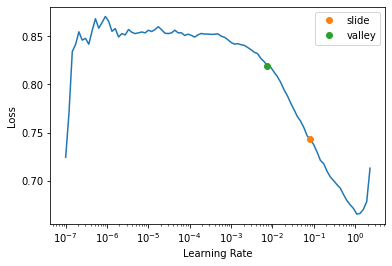

In [9]:
learn.lr_find(suggest_funcs=(slide, valley))

In [18]:
learn.fit(16, lr=0.03)

## Submit to Kaggle

In [21]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [22]:
tst_dl = learn.dls.test_dl(tst_df)

In [ ]:
preds,_ = learn.get_preds(dl=tst_dl)

In [ ]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

## Ensembling

In [23]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [24]:
learns = [ensemble() for _ in range(5)]

In [25]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

## Final thoughts